## 必要な式一覧
正規分布の共分散行列が$y=0$と$y=1$で同じ場合。
$$
\begin{align}
p(x|y=0) &= \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{0})^{T}\Sigma^{-1}(x-\mu_{0})) \\
p(x|y=1) &= \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{1})^{T}\Sigma^{-1}(x-\mu_{1})) \\
p(y) &= \phi^{y}(1-\phi)^{1-y} \\
\end{align}
$$

最尤推定で算出した各パラメータ。
$$
\begin{align}
\phi &= \frac{1}{m}\sum_{i=1}^{m}y^{(i)} = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\} \\
\mu_{0} &= \frac{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=0\}x^{(i)}}{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=0\}} \\
\mu_{1} &= \frac{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\}x^{(i)}}{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\}} \\
\Sigma &= \frac{1}{m}\sum_{i=1}^{m}(x^{(i)}-\mu_{y^{(i)}})(x^{(i)}-\mu_{y^{(i)}})^{T} \\
\end{align}
$$

推論時にはargmaxを算出。
$$
\begin{align}
\DeclareMathOperator*{\argmax}{arg\,max} \\
\argmax_{y}p(x|y)=\argmax_{y}p(x|y)p(y) \\
\end{align}
$$

In [1]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli, multivariate_normal

%matplotlib inline

In [2]:
np.random.seed(0)

### 必要なクラス・関数を定義する。

In [3]:
# GDAを実装する
class GDA:
    def fit(self, X, y):
        self.phi = np.mean(y)
        self.mu0 = np.mean([xi for xi, yi in zip(X, y) if yi == 0], axis=0)
        self.mu1 = np.mean([xi for xi, yi in zip(X, y) if yi == 1], axis=0)
        outer_prods = []
        for xi, yi in zip(X, y):
            x_minus_mu = xi - (self.mu0 if yi == 0 else self.mu1)
            outer_prods.append(np.outer(x_minus_mu, x_minus_mu))
        self.sigma = np.mean(outer_prods, axis=0)

        self.ber = bernoulli(p=self.phi)
        self.gauss0 = multivariate_normal(mean=self.mu0, cov=self.sigma)
        self.gauss1 = multivariate_normal(mean=self.mu1, cov=self.sigma)

    def predict_proba(self, X):
        prob0 = self.gauss0.pdf(X) * self.ber.pmf(0)
        prob1 = self.gauss1.pdf(X) * self.ber.pmf(1)
        probs = np.concatenate([
            np.expand_dims(prob0, axis=1), np.expand_dims(prob1, axis=1)
        ], axis=1)
        probs = np.apply_along_axis(lambda prob: prob / prob.sum(), 1, probs)

        return probs

In [4]:
# 描画用関数を作成する
def plot(ax,
         X0=None, X1=None,
         mean0=None, mean1=None, cov0=None, cov1=None,
         clf=None, threshold=0.01,
         data=False, contour=False, boundary=False):
    X = np.concatenate([X0, X1], axis=0)
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    # データを描画する
    if data:
        ax.scatter(X0[:, 0], X0[:, 1], color='blue')
        ax.scatter(X1[:, 0], X1[:, 1], color='red')

    # 等高線を描画する
    if contour:
        N = 200
        X = np.linspace(x_min, x_max, N)
        Y = np.linspace(y_min, y_max, N)
        X, Y = np.meshgrid(X, Y)
        pos = np.dstack((X, Y))
        Z0 = multivariate_normal.pdf(pos, mean=mean0, cov=cov0)
        Z1 = multivariate_normal.pdf(pos, mean=mean1, cov=cov1)
        ax.contour(X, Y, Z0, cmap='Blues')
        ax.contour(X, Y, Z1, cmap='Reds')

    # 決定境界を描画する
    if boundary:
        # https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
        data = np.c_[xx.ravel(), yy.ravel()]
        Z = clf.predict_proba(data)
        Z = np.apply_along_axis(lambda z: abs(z[0] - z[1]) <= threshold, 1, Z)
        db = data[np.where(Z)[0]]
        ax.plot(db[:, 0], db[:, 1], color='green')

### データを準備する。

In [5]:
mean0 = np.array([2, 0])
mean1 = np.array([3, 3])
cov0 = np.array([[1, 0], [0, 1]])
cov1 = np.array([[1.2, -0.2], [-0.2, 0.8]])
size = 80

X0 = np.random.multivariate_normal(mean=mean0, cov=cov0, size=size)
y0 = np.zeros(size, dtype=np.int64)
X1 = np.random.multivariate_normal(mean=mean1, cov=cov1, size=size)
y1 = np.ones(size, dtype=np.int64)

X = np.concatenate([X0, X1], axis=0)
y = np.concatenate([y0, y1], axis=0)

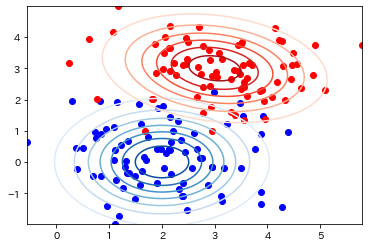

In [6]:
ax = plt.subplot(1, 1, 1)
plot(ax, X0, X1, mean0, mean1, cov0, cov1, data=True, contour=True)

### GDAの結果を描画する。

In [7]:
gda = GDA()
gda.fit(X, y)

In [8]:
print(f'phi: {gda.phi}')
print(f'mu0: {gda.mu0}')
print(f'mu1: {gda.mu1}')
print(f'sigma:')
print(gda.sigma)

phi: 0.5
mu0: [2.01370155 0.19356015]
mu1: [3.1037893  2.91784232]
sigma:
[[ 1.09855886 -0.09519291]
 [-0.09519291  0.83140581]]


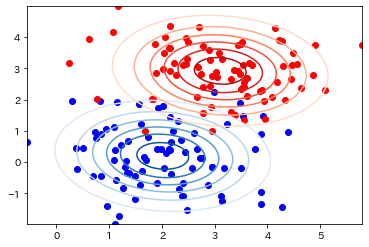

In [9]:
# 各データは異なる正規分布から抽出したが、GDAでは共分散行列が共通なので、同じ形の等高線が引かれる。
ax = plt.subplot(1, 1, 1)
plot(ax, X0, X1, gda.mu0, gda.mu1, gda.sigma, gda.sigma, data=True, contour=True)

### 決定境界を描画する。

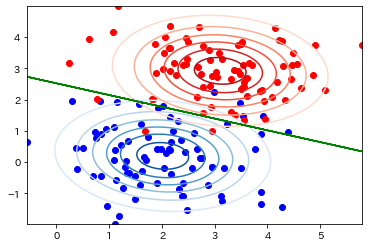

In [10]:
# 決定境界は大体線形になった。
ax = plt.subplot(1, 1, 1)
plot(ax, X0, X1, gda.mu0, gda.mu1, gda.sigma, gda.sigma, gda, data=True, contour=True, boundary=True)

### （おまけ）共分散行列が異なる擬似GDAを作成し、決定境界を描画する。
Andrew先生曰く、
```
Why do we use two separate means, mu0 and mu1, and a single covariance matrix, sigma?
It turns out that if you choose to build a model this way, the decision boundary ends up being linear.
It turns out you can choose to use two separate covariate matrix, sigma0 and sigma1, that will actually work OK.
It's actually very reasonable way to do so as well, but you double the number of parameters roughly, and you end up with a decision boundary that isn't linear anymore.
```
とのことで、共分散行列が共通の場合に決定境界が線形になることは上で確認したので、共分散行列が異なる場合にどうなるかを確認する。

In [11]:
# パラメーターを固定で擬似GDAを実装する
class PseudoGDA(GDA):
    def fit(self):
        self.phi = 0.5
        self.mu0 = mean0
        self.mu1 = mean1
        self.sigma0 = cov0
        self.sigma1 = cov1

        self.ber = bernoulli(p=self.phi)
        self.gauss0 = multivariate_normal(mean=self.mu0, cov=self.sigma0)
        self.gauss1 = multivariate_normal(mean=self.mu1, cov=self.sigma1)

In [12]:
pgda = PseudoGDA()
pgda.fit()

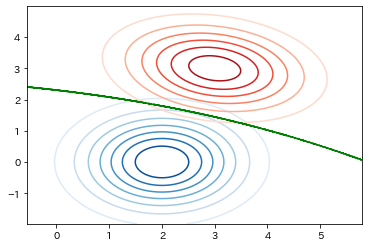

In [13]:
# 決定境界が非線形になった！！
ax = plt.subplot(1, 1, 1)
plot(ax, X0, X1, pgda.mu0, pgda.mu1, pgda.sigma0, pgda.sigma1, pgda, contour=True, boundary=True)

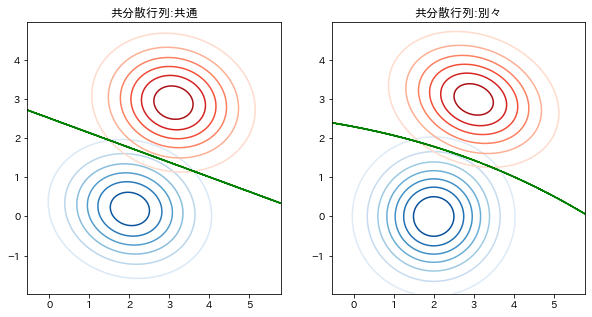

In [14]:
# 2つの結果を並べる。
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title('共分散行列:共通')
plot(ax1, X0, X1, gda.mu0, gda.mu1, gda.sigma, gda.sigma, gda, contour=True, boundary=True)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('共分散行列:別々')
plot(ax2, X0, X1, pgda.mu0, pgda.mu1, pgda.sigma0, pgda.sigma1, pgda, contour=True, boundary=True)